In [1]:
import logging
import numpy as np
import pandas as pd
from tqdm import tqdm
from prophet import Prophet
from sklearn.metrics import (
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
from pathlib import Path
from vangja.components import LinearTrend, FourierSeasonality, Constant
from vangja.data_utils import (
    download_data,
    process_data,
    generate_train_test_df_around_point,
)

logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled = True

Importing plotly failed. Interactive plots will not work.


# Fetch data

In [2]:
dfs = download_data(Path("./data"))
indexes = process_data(dfs[0])
smp = [index for index in indexes if index["series"].iloc[0] == "^GSPC"]
gspc_tickers = process_data(dfs[1])

# Generate models

In [6]:
# model_components = [
#     [LinearTrend(pool_cols="series", pool_type=pt) for pt in ["individual", "partial"]],
#     [
#         FourierSeasonality(
#             period=365.25, series_order=10, pool_cols="series", pool_type=pt
#         )
#         for pt in ["individual", "partial"]
#     ],
#     [
#         FourierSeasonality(
#             period=91.3125, series_order=n, pool_cols="series", pool_type=pt
#         )
#         for n in range(7, 10)
#         for pt in ["individual", "partial"]
#     ],
#     [
#         FourierSeasonality(
#             period=30.4375, series_order=n, pool_cols="series", pool_type=pt
#         )
#         for n in range(4, 7)
#         for pt in ["individual", "partial"]
#     ],
#     [
#         FourierSeasonality(period=7, series_order=3, pool_cols="series", pool_type=pt)
#         for pt in ["individual", "partial"]
#     ],
# ]

model_components = [
    [LinearTrend(allow_tune=False)],
    [
        FourierSeasonality(period=365.25, series_order=10, allow_tune=allow_tune)
        for allow_tune in [True]
    ],
    # [
    #     FourierSeasonality(period=91.3125, series_order=n, allow_tune=allow_tune)
    #     for n in range(7, 10)
    #     for allow_tune in [True, False]
    # ],
    # [
    #     FourierSeasonality(period=30.4375, series_order=n, allow_tune=allow_tune)
    #     for n in range(4, 7)
    #     for allow_tune in [True, False]
    # ],
    [
        FourierSeasonality(period=7, series_order=3, allow_tune=allow_tune)
        for allow_tune in [True, False]
    ],
]

# model_components = [
#     [LinearTrend(allow_tune=False, pool_cols="series", pool_type="individual")],
#     [
#         FourierSeasonality(
#             period=365.25,
#             series_order=10,
#             allow_tune=allow_tune,
#             pool_cols="series",
#             pool_type="individual",
#         )
#         for allow_tune in [True]
#     ],
#     # [
#     #     FourierSeasonality(
#     #         period=91.3125,
#     #         series_order=n,
#     #         allow_tune=allow_tune,
#     #         pool_cols="series",
#     #         pool_type="individual",
#     #     )
#     #     for n in range(7, 10)
#     #     for allow_tune in [True, False]
#     # ],
#     # [
#     #     FourierSeasonality(
#     #         period=30.4375,
#     #         series_order=n,
#     #         allow_tune=allow_tune,
#     #         pool_cols="series",
#     #         pool_type="individual",
#     #     )
#     #     for n in range(4, 7)
#     #     for allow_tune in [True, False]
#     # ],
#     [
#         FourierSeasonality(
#             period=7,
#             series_order=3,
#             allow_tune=allow_tune,
#             pool_cols="series",
#             pool_type="individual",
#         )
#         for allow_tune in [True, False]
#     ],
# ]

In [7]:
q = [(0, [mc]) for mc in model_components[0]]
models = []

while len(q):
    level, model = q.pop(0)
    if level + 1 == len(model_components):
        models.append(model)
        continue

    mcs = model_components[level + 1]
    for mc in mcs:
        # if mc.pool_type == "partial":
        #     q.append(
        #         (
        #             level + 1,
        #             model
        #             + [
        #                 Constant(
        #                     lower=-1, upper=1, pool_cols="series", pool_type="partial"
        #                 )
        #                 * mc
        #             ],
        #         )
        #     )

        q.append((level + 1, model + [mc]))
        q.append((level + 1, model))

In [8]:
def sum_models(models):
    s = None
    for model in models:
        if s is None:
            s = model
        else:
            s += model

    return s

In [9]:
models = (
    [
        LinearTrend() * (FourierSeasonality(365.25, 10) + FourierSeasonality(7, 3)),
        LinearTrend() * FourierSeasonality(365.25, 10),
        LinearTrend() * FourierSeasonality(7, 3),
        LinearTrend() + FourierSeasonality(365.25, 10) + FourierSeasonality(7, 3),
        LinearTrend() + FourierSeasonality(365.25, 10),
        LinearTrend() + FourierSeasonality(7, 3),
    ]
    + [
        model[0] * sum_models(model[1:]) if len(model) > 1 else model[0]
        for model in models
    ]
    + [sum_models(model) if len(model) > 1 else model[0] for model in models]
)

In [10]:
str_models = {""}
final_models = []
for model in models:
    str_model = str(model)
    if str_model in str_models:
        continue

    str_models.add(str_model)
    final_models.append(model)

len(final_models)

15

In [ ]:
str_models

{'',
 'LT(n=25,r=0.8,at=False,complete)',
 'LT(n=25,r=0.8,at=False,complete) * (FS(p=365.25,n=10,at=False,complete) + FS(p=7,n=3,at=False,complete))',
 'LT(n=25,r=0.8,at=False,complete) * (FS(p=365.25,n=10,at=True,complete) + FS(p=7,n=3,at=False,complete))',
 'LT(n=25,r=0.8,at=False,complete) * (FS(p=365.25,n=10,at=True,complete) + FS(p=7,n=3,at=True,complete))',
 'LT(n=25,r=0.8,at=False,complete) * FS(p=365.25,n=10,at=False,complete)',
 'LT(n=25,r=0.8,at=False,complete) * FS(p=365.25,n=10,at=True,complete)',
 'LT(n=25,r=0.8,at=False,complete) * FS(p=7,n=3,at=False,complete)',
 'LT(n=25,r=0.8,at=False,complete) * FS(p=7,n=3,at=True,complete)',
 'LT(n=25,r=0.8,at=False,complete) + FS(p=365.25,n=10,at=False,complete)',
 'LT(n=25,r=0.8,at=False,complete) + FS(p=365.25,n=10,at=False,complete) + FS(p=7,n=3,at=False,complete)',
 'LT(n=25,r=0.8,at=False,complete) + FS(p=365.25,n=10,at=True,complete)',
 'LT(n=25,r=0.8,at=False,complete) + FS(p=365.25,n=10,at=True,complete) + FS(p=7,n=3,at=Fals

# Test prophet

In [3]:
def get_prophet_metrics(y_trues, y_preds, horizon):
    result = None
    for y_true, y_pred in zip(y_trues, y_preds):
        group_name = y_true["series"].iloc[0]
        single_metrics = {"mse": {}, "rmse": {}, "mae": {}, "mape": {}}
        single_metrics["mse"][group_name] = mean_squared_error(
            y_true["y"], y_pred["yhat"][-horizon:]
        )
        single_metrics["rmse"][group_name] = root_mean_squared_error(
            y_true["y"], y_pred["yhat"][-horizon:]
        )
        single_metrics["mae"][group_name] = mean_absolute_error(
            y_true["y"], y_pred["yhat"][-horizon:]
        )
        single_metrics["mape"][group_name] = mean_absolute_percentage_error(
            y_true["y"], y_pred["yhat"][-horizon:]
        )
        if result is None:
            result = pd.DataFrame(single_metrics)
        else:
            result = pd.concat((result, pd.DataFrame(single_metrics)))

    return result

In [4]:
point = "2007-01-01"

train_df_smp, test_df_smp, scales_smp = generate_train_test_df_around_point(
    window=365 * 5, horizon=365, dfs=smp, for_prophet=True, point=point
)
train_df_ticker, test_df_tickers, scales_tickers = generate_train_test_df_around_point(
    window=91, horizon=365, dfs=gspc_tickers, for_prophet=True, point=point
)

In [5]:
context_prophet = Prophet(seasonality_mode="multiplicative")
context_prophet.fit(train_df_smp[0])
context_future = context_prophet.make_future_dataframe(
    periods=365, include_history=True
)
context_yhat = context_prophet.predict(context_future)
context_metrics = get_prophet_metrics(test_df_smp, [context_yhat], 365)
context_metrics

,mse,rmse,mae,mape
^GSPC,0.002121,0.046053,0.037282,0.035854


In [18]:
prophet_forecasts = []

for df, df_test in tqdm(zip(train_df_ticker, test_df_tickers)):
    prophet = Prophet(seasonality_mode="multiplicative", n_changepoints=5)
    # prophet.add_regressor("smp_weekly", standardize=False, mode="additive")
    # prophet.add_regressor("smp_yearly", standardize=False, mode="additive")
    # prophet.add_regressor("smp_yhat", standardize=False, mode="additive")

    train_df = df.copy()
    # train_df["smp_weekly"] = context_yhat[
    #     (context_yhat["ds"] >= train_df["ds"].iloc[0])
    #     & (context_yhat["ds"] <= train_df["ds"].iloc[-1])
    # ]["weekly"].to_numpy()
    # train_df["smp_yhat"] = context_yhat[
    #     (context_yhat["ds"] >= train_df["ds"].iloc[0])
    #     & (context_yhat["ds"] <= train_df["ds"].iloc[-1])
    # ]["yhat"].to_numpy()
    # train_df["smp_yearly"] = context_yhat[
    #     (context_yhat["ds"] >= train_df["ds"].iloc[0])
    #     & (context_yhat["ds"] <= train_df["ds"].iloc[-1])
    # ]["yearly"].to_numpy()

    prophet.fit(train_df)

    future = prophet.make_future_dataframe(periods=365, include_history=True)
    # future["smp_weekly"] = context_yhat[
    #     (context_yhat["ds"] >= future["ds"].iloc[0])
    #     & (context_yhat["ds"] <= future["ds"].iloc[-1])
    # ]["weekly"].to_numpy()
    # future["smp_yhat"] = context_yhat[
    #     (context_yhat["ds"] >= future["ds"].iloc[0])
    #     & (context_yhat["ds"] <= future["ds"].iloc[-1])
    # ]["yhat"].to_numpy()
    # future["smp_yearly"] = context_yhat[
    #     (context_yhat["ds"] >= future["ds"].iloc[0])
    #     & (context_yhat["ds"] <= future["ds"].iloc[-1])
    # ]["yearly"].to_numpy()

    prophet_forecasts.append(prophet.predict(future))

prophet_metrics = get_prophet_metrics(test_df_tickers, prophet_forecasts, 365)
prophet_metrics["mape"].mean()

93it [00:18,  4.14it/s]

In [ ]:
prophet_metrics

,mse,rmse,mae,mape
BEN,0.114833,0.338870,0.314271,0.279807
EIX,0.085392,0.292219,0.261288,0.218951
JNPR,1.574101,1.254632,1.062711,0.761442
RCL,0.166509,0.408055,0.350142,0.375900
LEG,0.011349,0.106531,0.079706,0.098670
...,...,...,...,...
WMB,0.734262,0.856891,0.741689,0.623883
RF,0.266696,0.516426,0.437445,0.557220
AMAT,0.004199,0.064799,0.051362,0.049008
VRSN,1.114170,1.055542,0.901987,0.717176


# Test model

In [14]:
def run_test(idx, point):
    train_df_smp, test_df_smp, scales_smp = generate_train_test_df_around_point(
        window=365 * 35, horizon=365, dfs=smp, for_prophet=False, point=point
    )
    model = final_models[idx]
    model.fit(train_df_smp, progressbar=False)
    map_approx = model.map_approx
    model_metrics = []

    for smp_ticker in tqdm(smp + smp_tickers):
        check = generate_train_test_df_around_point(
            window=365 * 1,
            horizon=365,
            dfs=[smp_ticker],
            for_prophet=False,
            point=point,
        )
        if check is None:
            continue

        train_df_tickers, test_df_tickers, scales_tickers = check
        model.map_approx = map_approx
        model.tune(train_df_tickers, progressbar=False)
        yhat = model.predict(365)
        yhat.to_csv(f"./out/model_{idx}_series_{smp_ticker['series'].iloc[0]}.csv")
        model_metrics.append(model.metrics(test_df_tickers, yhat, pool_cols="series"))

    print(f"{idx} - {model}: {pd.concat(model_metrics)['mape'].mean()}")
    return pd.concat(model_metrics)

In [96]:
# from joblib import Parallel, delayed

"""
100%|██████████| 127/127 [09:50<00:00,  4.65s/it]
0 - LT(n=25,r=0.8,at=False,complete) * (FS(p=365.25,n=10,at=True,complete) + FS(p=7,n=3,at=True,complete)): 0.15938053967032853
100%|██████████| 127/127 [05:26<00:00,  2.57s/it]
1 - LT(n=25,r=0.8,at=False,complete) * FS(p=365.25,n=10,at=True,complete): 0.15760077719458276
100%|██████████| 127/127 [06:05<00:00,  2.88s/it]
2 - LT(n=25,r=0.8,at=False,complete) * (FS(p=365.25,n=10,at=True,complete) + FS(p=7,n=3,at=False,complete)): 0.1613983544054207
100%|██████████| 127/127 [05:36<00:00,  2.65s/it]
3 - LT(n=25,r=0.8,at=False,complete) * FS(p=7,n=3,at=True,complete): 0.2135529074152472
100%|██████████| 127/127 [03:38<00:00,  1.72s/it]
4 - LT(n=25,r=0.8,at=False,complete): 0.2123689870169386
100%|██████████| 127/127 [03:48<00:00,  1.80s/it]
5 - LT(n=25,r=0.8,at=False,complete) * FS(p=7,n=3,at=False,complete): 0.21387403836166552
"""

point = "2006-01-01"
all_metrics = []
# all_metrics = Parallel(n_jobs=8, prefer="threads")(
#     delayed(run_test)(idx, point) for idx, model in enumerate(final_models[:5])
# )

# with open("./out/models.txt", "w") as f:
#     for idx, model in enumerate(final_models):
#         f.write(f"model_{idx}: {model}\n")

for idx, model in enumerate(final_models):
    all_metrics.append(run_test(idx, point))

100%|██████████| 504/504 [34:48<00:00,  4.14s/it]


0 - LT(n=25,r=0.8,at=False,complete) * (FS(p=365.25,n=10,at=False,complete) + FS(p=7,n=3,at=False,complete)): 0.15084780966568953


100%|██████████| 504/504 [26:51<00:00,  3.20s/it]


1 - LT(n=25,r=0.8,at=False,complete) * FS(p=365.25,n=10,at=False,complete): 0.15101299880893668


100%|██████████| 504/504 [14:31<00:00,  1.73s/it]


2 - LT(n=25,r=0.8,at=False,complete) * FS(p=7,n=3,at=False,complete): 0.23179868015950725


100%|██████████| 504/504 [21:38<00:00,  2.58s/it]


3 - LT(n=25,r=0.8,at=False,complete) + FS(p=365.25,n=10,at=False,complete) + FS(p=7,n=3,at=False,complete): 0.14906985388701274


100%|██████████| 504/504 [19:49<00:00,  2.36s/it]


4 - LT(n=25,r=0.8,at=False,complete) + FS(p=365.25,n=10,at=False,complete): 0.14915277599146487


100%|██████████| 504/504 [14:01<00:00,  1.67s/it]


5 - LT(n=25,r=0.8,at=False,complete) + FS(p=7,n=3,at=False,complete): 0.23083132671920667


100%|██████████| 504/504 [21:44<00:00,  2.59s/it]


6 - LT(n=25,r=0.8,at=False,complete) * (FS(p=365.25,n=10,at=True,complete) + FS(p=7,n=3,at=True,complete)): 0.14998936264585022


100%|██████████| 504/504 [17:39<00:00,  2.10s/it]


7 - LT(n=25,r=0.8,at=False,complete) * FS(p=365.25,n=10,at=True,complete): 0.1491083305827519


100%|██████████| 504/504 [20:04<00:00,  2.39s/it]


8 - LT(n=25,r=0.8,at=False,complete) * (FS(p=365.25,n=10,at=True,complete) + FS(p=7,n=3,at=False,complete)): 0.15158811222516175


100%|██████████| 504/504 [17:11<00:00,  2.05s/it]


9 - LT(n=25,r=0.8,at=False,complete) * FS(p=7,n=3,at=True,complete): 0.2328139526374169


100%|██████████| 504/504 [18:32<00:00,  2.21s/it]


10 - LT(n=25,r=0.8,at=False,complete): 0.23130798615609033


100%|██████████| 504/504 [20:50<00:00,  2.48s/it]


11 - LT(n=25,r=0.8,at=False,complete) + FS(p=365.25,n=10,at=True,complete) + FS(p=7,n=3,at=True,complete): 0.1466321610760913


100%|██████████| 504/504 [16:55<00:00,  2.02s/it]


12 - LT(n=25,r=0.8,at=False,complete) + FS(p=365.25,n=10,at=True,complete): 0.1471390167141869


100%|██████████| 504/504 [19:30<00:00,  2.32s/it]


13 - LT(n=25,r=0.8,at=False,complete) + FS(p=365.25,n=10,at=True,complete) + FS(p=7,n=3,at=False,complete): 0.14837076729903897


100%|██████████| 504/504 [16:54<00:00,  2.01s/it]

14 - LT(n=25,r=0.8,at=False,complete) + FS(p=7,n=3,at=True,complete): 0.23237458534332991


In [107]:
point = "2007-01-01"

train_df_smp, test_df_smp, scales_smp = generate_train_test_df_around_point(
    window=365 * 35, horizon=365, dfs=smp, for_prophet=False, point=point
)

model_metrics = []
tested_models = []

for smp_ticker in tqdm(smp + smp_tickers):
    check = generate_train_test_df_around_point(
        window=365 * 1, horizon=365, dfs=[smp_ticker], for_prophet=False, point=point
    )
    if check is None:
        continue

    train_df_tickers, test_df_tickers, scales_tickers = check
    ticker = train_df_tickers["series"].iloc[0]
    if ticker not in model_idxs:
        continue
    
    model_idx = model_idxs[ticker]
    model = final_models[model_idx]
    if model_idx not in tested_models:
        model.fit(train_df_smp, progressbar=False)
        tested_models.append(model_idx)

    map_approx = model.map_approx    
    model.tune(train_df_tickers, progressbar=False)
    yhat = model.predict(365)
    model_metrics.append(model.metrics(test_df_tickers, yhat, pool_cols="series"))
    model.map_approx = map_approx

print(f"{pd.concat(model_metrics)['mape'].mean()}")

  0%|          | 0/504 [00:00<?, ?it/s]

100%|██████████| 504/504 [35:32<00:00,  4.23s/it] 

0.1726415857563341


In [14]:
model = LinearTrend() * (
    FourierSeasonality(365.25, 10, allow_tune=True)
    + FourierSeasonality(7, 3, allow_tune=True)
)
model_metrics = []
point = "2007-01-01"

train_df_smp, test_df_smp, scales_smp = generate_train_test_df_around_point(
    window=365 * 35, horizon=365, dfs=smp, for_prophet=False, point=point
)
model.fit(train_df_smp, progressbar=True)

for smp_ticker in tqdm(smp + smp_tickers):
    check = generate_train_test_df_around_point(
        window=365 * 1,
        horizon=365,
        dfs=[smp_ticker],
        for_prophet=False,
        point=point,
    )
    if check is None:
        continue

    train_df_tickers, test_df_tickers, scales_tickers = check
    model.tune(train_df_tickers, progressbar=False)
    yhat = model.predict(365)
    model_metrics.append(model.metrics(test_df_tickers, yhat, pool_cols="series"))

print(f"{model}: {pd.concat(model_metrics)['mape'].mean()}")

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f81fc97d1c0>>
Traceback (most recent call last):
  File "/home/jovan/miniconda3/envs/new_pymc_env/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Output()

  0%|          | 1/504 [00:12<1:42:11, 12.19s/it]


KeyboardInterrupt: 

In [ ]:
model = LinearTrend(n_changepoints=25, changepoint_range=0.8) * (
    FourierSeasonality(365.25, 10, allow_tune=True)
    # + FourierSeasonality(91.3125, 7, allow_tune=True)
    # + FourierSeasonality(30.4375, 5, allow_tune=True)
    + FourierSeasonality(7, 3, allow_tune=False)
)
point = "2007-01-01"

train_df_smp, test_df_smp, scales_smp = generate_train_test_df_around_point(
    window=365 * 5, horizon=365, dfs=[indexes[1]], for_prophet=False, point=point
)

model.fit(train_df_smp, mcmc_samples=1000)
yhat = model.predict(365)
print(model.metrics(test_df_smp, yhat, pool_cols="series")["mape"].iloc[0])
model.plot(yhat, test_df_smp, pool_cols="series")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lt_0 - slope, lt_0 - delta, lt_0 - intercept, fs_0 - beta(p=365.25,n=10), fs_1 - beta(p=7,n=3), sigma]


Output()

0.41147413187858944


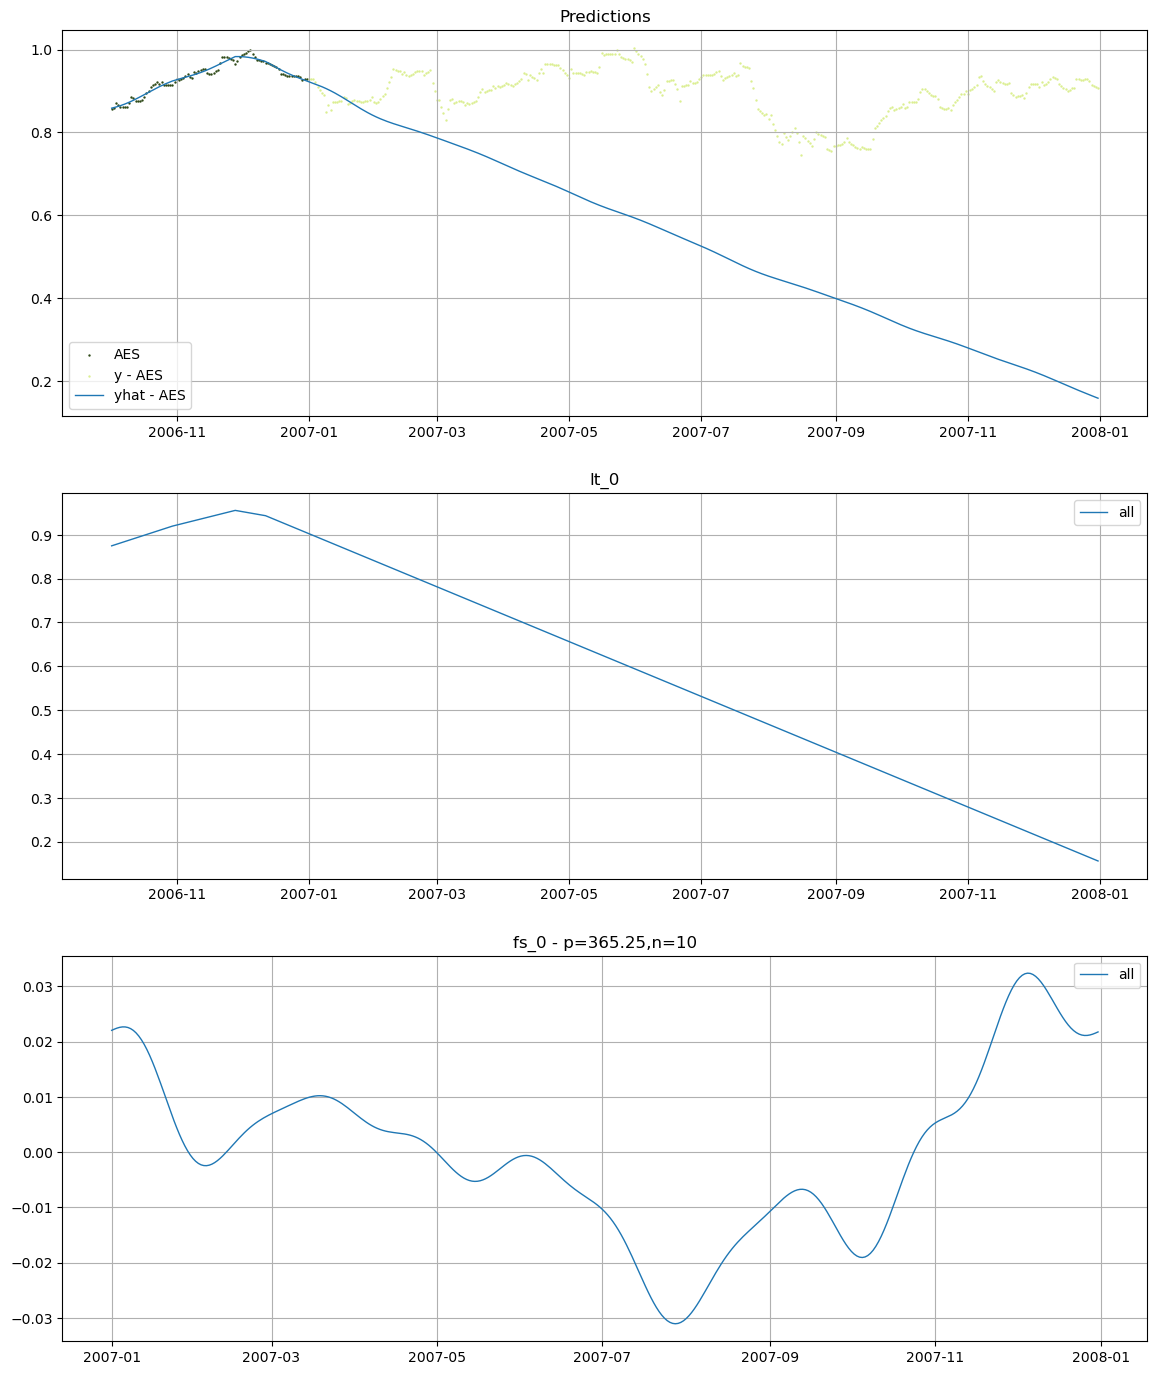

In [11]:
model_metrics = []

for gspc_ticker in tqdm(gspc_tickers):
    train_df_tickers, test_df_tickers, scales_tickers = generate_train_test_df_around_point(
        window=91,
        horizon=365,
        dfs=[gspc_ticker],
        for_prophet=False,
        point=point,
    )

    model.tune(train_df_tickers, progressbar=False)
    yhat = model.predict(365)
    model_metrics.append(model.metrics(test_df_tickers, yhat, pool_cols="series"))

final_metrics = pd.concat(model_metrics)
print(f"{model}: {final_metrics['mape'].mean()}")

In [ ]:
final_metrics

0.226718387077751


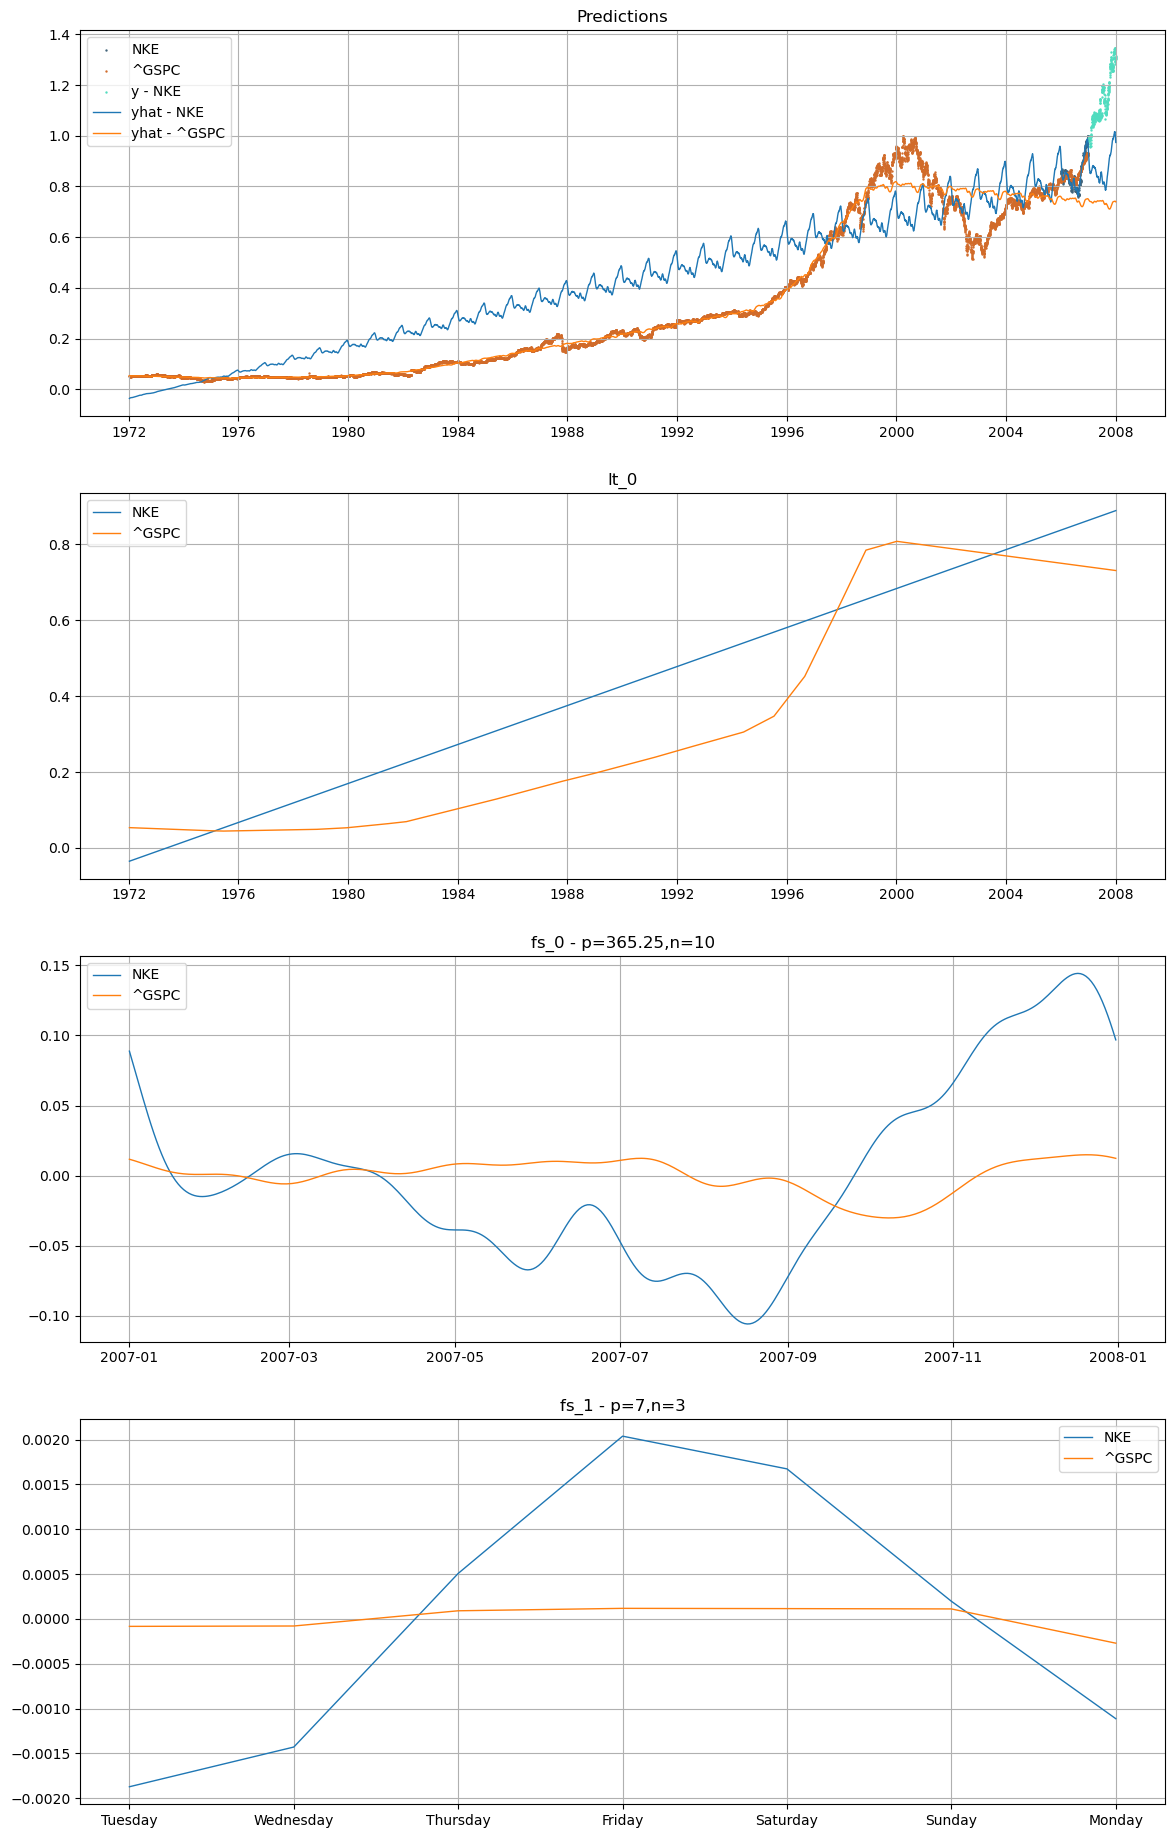

In [21]:
model = LinearTrend(pool_cols="series", pool_type="individual") * (
    FourierSeasonality(
        365.25, 10, allow_tune=False, pool_cols="series", pool_type="partial"
    )
    + FourierSeasonality(
        7, 3, allow_tune=False, pool_cols="series", pool_type="partial"
    )
)
point = "2007-01-01"

train_df_smp, test_df_smp, scales_smp = generate_train_test_df_around_point(
    window=365 * 35, horizon=365, dfs=smp, for_prophet=False, point=point
)
train_df_tickers, test_df_tickers, scales_tickers = generate_train_test_df_around_point(
    window=365,
    horizon=365,
    dfs=[smp_tickers[-1]],
    for_prophet=False,
    point=point,
)

model.fit(pd.concat([train_df_smp, train_df_tickers]), progressbar=True)
yhat = model.predict(365)
print(
    model.metrics(pd.concat([test_df_smp, test_df_tickers]), yhat, pool_cols="series")[
        "mape"
    ].iloc[0]
)
model.plot(yhat, test_df_tickers, pool_cols="series")

In [70]:
def run_test_2(idx, point):
    train_df_smp, test_df_smp, scales_smp = generate_train_test_df_around_point(
        window=365 * 35, horizon=365, dfs=smp, for_prophet=False, point=point
    )
    model = final_models[idx]
    model.fit(train_df_smp, progressbar=False)
    map_approx = model.map_approx
    model_metrics = []

    check = generate_train_test_df_around_point(
        window=365 * 1,
        horizon=365,
        dfs=smp + smp_tickers[::4],
        for_prophet=False,
        point=point,
    )

    train_df_tickers, test_df_tickers, scales_tickers = check
    model.map_approx = map_approx
    model.tune(train_df_tickers, progressbar=True)
    yhat = model.predict(365)
    yhat.to_csv(f"./out/single_model_{idx}.csv")
    model_metrics = model.metrics(test_df_tickers, yhat, pool_cols="series")

    print(f"{idx} - {model}: {model_metrics['mape'].mean()}")
    return model_metrics